In [4]:
# import torch
# torch_version = torch.__version__.split('+')[0]  # e.g., '2.1.0'
# url = f"https://data.pyg.org/whl/torch-{torch_version}.html"

# Now install with pip
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f {url}


Looking in links: https://data.pyg.org/whl/torch-2.6.0.html


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Using cached torch_scatter-2.1.2-cp310-cp310-win_amd64.whl
  Using cached torch_sparse-0.6.18-cp310-cp310-win_amd64.whl
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached aiohttp-3.11.14-cp310-cp310-win_amd64.whl (442 kB)
  Using cached yarl-1.18.3-cp310-cp310-win_amd64.whl (90 kB)
  Using cached frozenlist-1.5.0-cp310-cp310-win_amd64.whl (51 kB)
  Using cached propcache-0.3.0-cp310-cp310-win_amd64.whl (44 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Using cached multidict-6.2.0-cp310-cp310-win_amd64.whl (29 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl (7.6 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
import os

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import kneighbors_graph


In [6]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [14]:
# url = "https://raw.githubusercontent.com/akashvenus/Final_Project/refs/heads/main/sets1/train.csv"
df = pd.read_csv("train.csv")
df

,Unnamed: 0,destination port,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,fwd packet length mean,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
0,127724,53,23855,1,1,42,114,42,42,42.000000,...,20,0.0,0.0000,0,0,0.0,0.00000,0,0,BENIGN
1,74669,53108,115,1,1,0,0,0,0,0.000000,...,20,0.0,0.0000,0,0,0.0,0.00000,0,0,BENIGN
2,52277,53,30920,1,1,54,82,54,54,54.000000,...,32,0.0,0.0000,0,0,0.0,0.00000,0,0,BENIGN
3,33733,443,116886492,17,17,946,5030,292,0,55.647059,...,20,392253.5,369954.7324,653851,130656,58000000.0,59459.90212,58000000,57900000,BENIGN
4,66283,21,8806152,9,15,109,188,31,0,12.111111,...,32,0.0,0.0000,0,0,0.0,0.00000,0,0,FTP-Patator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88467,35942,443,5755364,7,4,599,156,517,0,85.571429,...,32,126402.0,0.0000,126402,126402,5628946.0,0.00000,5628946,5628946,BENIGN
88468,23948,53,47489,2,2,64,532,32,32,32.000000,...,32,0.0,0.0000,0,0,0.0,0.00000,0,0,BENIGN
88469,21149,443,3836920,6,7,1076,394,517,0,179.333333,...,20,0.0,0.0000,0,0,0.0,0.00000,0,0,BENIGN
88470,90942,80,5473398,3,1,0,0,0,0,0.000000,...,32,0.0,0.0000,0,0,0.0,0.00000,0,0,Web Attack � Brute Force


In [15]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [16]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [19]:
import joblib

scaler = joblib.load("scaler.pkl")

['ack flag count' 'act_data_pkt_fwd' 'active max' 'active mean'
 'active min' 'active std' 'average packet size' 'avg bwd segment size'
 'avg fwd segment size' 'bwd avg bulk rate' 'bwd avg bytes/bulk'
 'bwd avg packets/bulk' 'bwd header length' 'bwd iat max' 'bwd iat mean'
 'bwd iat min' 'bwd iat std' 'bwd iat total' 'bwd packet length max'
 'bwd packet length mean' 'bwd packet length min' 'bwd packet length std'
 'bwd packets/s' 'bwd psh flags' 'bwd urg flags' 'cwe flag count'
 'destination port' 'down/up ratio' 'ece flag count' 'fin flag count'
 'flow bytes/s' 'flow duration' 'flow iat max' 'flow iat mean'
 'flow iat min' 'flow iat std' 'flow packets/s' 'fwd avg bulk rate'
 'fwd avg bytes/bulk' 'fwd avg packets/bulk' 'fwd header length'
 'fwd header length.1' 'fwd iat max' 'fwd iat mean' 'fwd iat min'
 'fwd iat std' 'fwd iat total' 'fwd packet length max'
 'fwd packet length mean' 'fwd packet length min' 'fwd packet length std'
 'fwd packets/s' 'fwd psh flags' 'fwd urg flags' 'idle m

In [20]:
X = df[scaler.feature_names_in_]
y = df['label'].values
num_nodes = len(df)

In [21]:
X_scaled = scaler.transform(X)

In [22]:
train_idx_np, test_idx_np = train_test_split(
    np.arange(num_nodes),
    test_size=0.33,
    stratify=y,
    random_state=DEFAULT_RANDOM_SEED
)

In [23]:
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx_np] = True

In [24]:
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_idx_np] = True

In [25]:
k = 5
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)

row_idx, col_idx = knn_graph.nonzero()
edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

# Convert to PyG data
x = torch.tensor(X_scaled, dtype=torch.float)
y_torch = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y_torch)
print(data)

d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program 

Data(x=[88472, 78], edge_index=[2, 442360], y=[88472])


C:\Users\Arild\AppData\Local\Temp\ipykernel_10272\4049555578.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)


In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

model = GraphNet(
    in_channels=x.shape[1],  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2           # final classes (0=Benign, 1=Attack)
)


loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [35]:
epochs = 80
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # shape: [num_nodes, 2]

    # Compute loss on train_mask only
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Evaluate on test set
    if epoch % 10 == 0 or epoch == epochs:
        model.eval()
        with torch.no_grad():
            out_test = out[test_mask]
            pred_test = out_test.argmax(dim=1)
            y_true_test = data.y[test_mask]

            acc = accuracy_score(y_true_test.cpu(), pred_test.cpu())
            print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f} | Test Accuracy: {acc:.4f}")


Epoch 10/80 | Loss: 0.1867 | Test Accuracy: 0.9095
Epoch 20/80 | Loss: 0.1222 | Test Accuracy: 0.9543
Epoch 30/80 | Loss: 0.1024 | Test Accuracy: 0.9533
Epoch 40/80 | Loss: 0.0870 | Test Accuracy: 0.9645
Epoch 50/80 | Loss: 0.0798 | Test Accuracy: 0.9650
Epoch 60/80 | Loss: 0.0791 | Test Accuracy: 0.9658
Epoch 70/80 | Loss: 0.0683 | Test Accuracy: 0.9730
Epoch 80/80 | Loss: 0.0658 | Test Accuracy: 0.9734


In [36]:
model.eval()
with torch.no_grad():
    out_all = model(data.x, data.edge_index)
    pred_all = out_all.argmax(dim=1)

    # Evaluate on test_mask
    y_true_test = data.y[test_mask]
    y_pred_test = pred_all[test_mask]

    # Basic metrics
    acc_test  = accuracy_score(y_true_test.cpu(), y_pred_test.cpu())
    prec_test = precision_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    rec_test  = recall_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    f1_test   = f1_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')

    tn, fp, fn, tp = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu()).ravel()
    fpr_test = fp / (fp + tn)

    print("\nFinal Test Metrics (Node-Level Classification):")
    print("-----------------------------------------------")
    print(f"Accuracy:    {acc_test:.4f}")
    print(f"Precision:   {prec_test:.4f}")
    print(f"Recall:      {rec_test:.4f}")
    print(f"F1-Score:    {f1_test:.4f}")
    print(f"False Pos Rate (FPR): {fpr_test:.4f}")
    print(classification_report(y_true_test.cpu(), y_pred_test.cpu(), target_names=['Benign (0)', 'Attack (1)']))


Final Test Metrics (Node-Level Classification):
-----------------------------------------------
Accuracy:    0.9750
Precision:   0.9384
Recall:      0.9401
F1-Score:    0.9393
False Pos Rate (FPR): 0.0160
              precision    recall  f1-score   support

  Benign (0)       0.98      0.98      0.98     23185
  Attack (1)       0.94      0.94      0.94      6011

    accuracy                           0.97     29196
   macro avg       0.96      0.96      0.96     29196
weighted avg       0.97      0.97      0.97     29196



In [37]:
torch.save(model.state_dict(), "GNN_DNN_weights.pth")


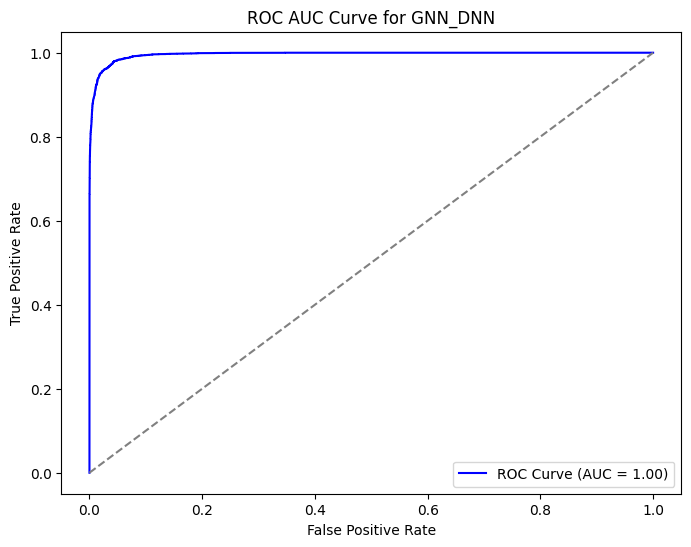

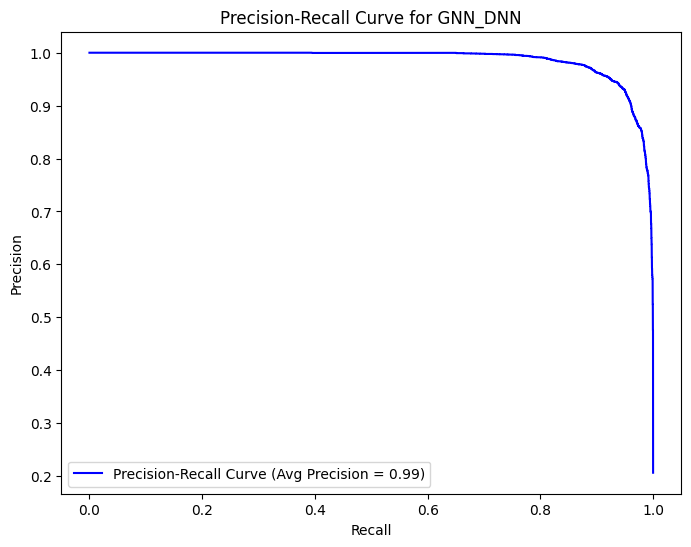

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc,  average_precision_score

model_name = "GNN_DNN"

with torch.no_grad():
    out_prob = out_all.exp()               # Convert from log-probs to probabilities
    y_proba_test = out_prob[test_mask, 1]  # Probability of class=1 for test nodes

# Convert to numpy arrays
y_true_test_np = y_true_test.cpu().numpy()
y_proba_test_np = y_proba_test.cpu().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test_np, y_proba_test_np)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_test_np, y_proba_test_np)
avg_precision = average_precision_score(y_true_test_np, y_proba_test_np)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue',
         label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {model_name}')
plt.legend(loc='lower left')
plt.show()